In [2]:
# --- 1. Import thư viện ---
import json
import pandas as pd
import re
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline

In [3]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)
    return text.strip()

In [4]:
data = []
with open(r'D:\Personal Project\text-topic-classifier\data\News_Category_Dataset_v3.json','r') as f:
    for line in f:
        data.append(json.loads(line))

data = pd.DataFrame(data)

In [5]:
category_mapping = {
    'ARTS & CULTURE': 'ARTS',
    'CULTURE & ARTS': 'ARTS',

    'PARENTS': 'PARENTING',

    'WORLDPOST': 'WORLD',
    'THE WORLDPOST': 'WORLD',
    'WORLD NEWS': 'WORLD',

    'STYLE & BEAUTY': 'STYLE',

    'HOME & LIVING': 'LIFESTYLE',
    'WELLNESS': 'LIFESTYLE',
    'HEALTHY LIVING': 'LIFESTYLE',

    'FOOD & DRINK': 'FOOD',
    'TASTE': 'FOOD',

    'GREEN': 'ENVIRONMENT',

    'COLLEGE': 'EDUCATION',

    'MONEY': 'BUSINESS',

    'LATINO VOICES': 'IDENTITY',
    'QUEER VOICES': 'IDENTITY',
    'BLACK VOICES': 'IDENTITY',
    'WOMEN': 'IDENTITY',

    'U.S. NEWS': 'POLITICS',
}

data['category'] = data['category'].replace(category_mapping)
data['text'] = data['headline'] + '. ' + data['short_description']
data = data[['text','category']]
data['text'] = data['text'].apply(clean_text)

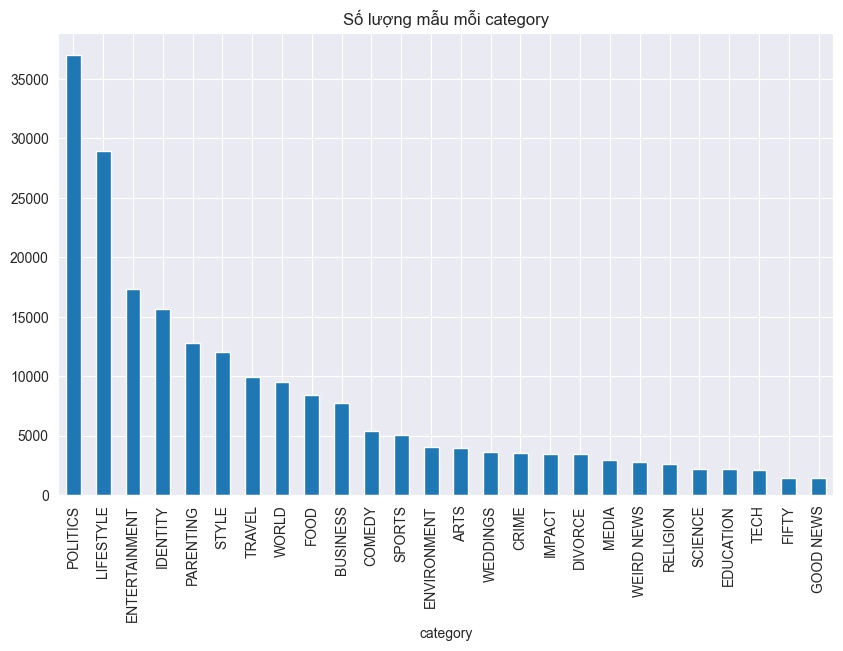

In [6]:
# --- 6. Thống kê dữ liệu ---
plt.figure(figsize=(10,6))
data['category'].value_counts().plot(kind='bar')
plt.title("Số lượng mẫu mỗi category")
plt.show()

In [7]:
le = LabelEncoder()
x = data['text']
y = le.fit_transform(data['category'])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42,stratify=y)

In [8]:
cls = ImbPipeline(steps=[
    ('vectorizer', TfidfVectorizer(stop_words='english', ngram_range=(1,2), min_df=2, max_df=0.9)),
    ('oversample', RandomOverSampler(random_state=42)),
    ('classifier', LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs', n_jobs=-1)),

])
cls.fit(x_train, y_train)

C:\Users\Vietil\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.9, min_df=2, ngram_range=(1, 2),
                                 stop_words='english')),
                ('oversample', RandomOverSampler(random_state=42)),
                ('classifier',
                 LogisticRegression(max_iter=1000, multi_class='multinomial',
                                    n_jobs=-1))])

In [9]:
y_pred = cls.predict(x_test)
print(classification_report(
    le.inverse_transform(y_test),
    le.inverse_transform(y_pred),
    zero_division=0
))

               precision    recall  f1-score   support

         ARTS       0.50      0.61      0.55       784
     BUSINESS       0.54      0.61      0.57      1550
       COMEDY       0.48      0.51      0.49      1080
        CRIME       0.46      0.65      0.54       712
      DIVORCE       0.76      0.76      0.76       685
    EDUCATION       0.43      0.59      0.50       432
ENTERTAINMENT       0.72      0.68      0.70      3473
  ENVIRONMENT       0.49      0.61      0.54       813
        FIFTY       0.26      0.26      0.26       280
         FOOD       0.74      0.84      0.78      1687
    GOOD NEWS       0.30      0.31      0.31       280
     IDENTITY       0.62      0.53      0.57      3127
       IMPACT       0.35      0.42      0.38       697
    LIFESTYLE       0.78      0.70      0.74      5792
        MEDIA       0.48      0.58      0.53       589
    PARENTING       0.69      0.74      0.71      2549
     POLITICS       0.84      0.70      0.76      7396
     RELI

In [ ]:
joblib.dump(cls, r"D:\Personal Project\text-topic-classifier\outputs\text_classifier.pkl")
joblib.dump(le, r"D:\Personal Project\text-topic-classifier\outputs\label_encoder.pkl")

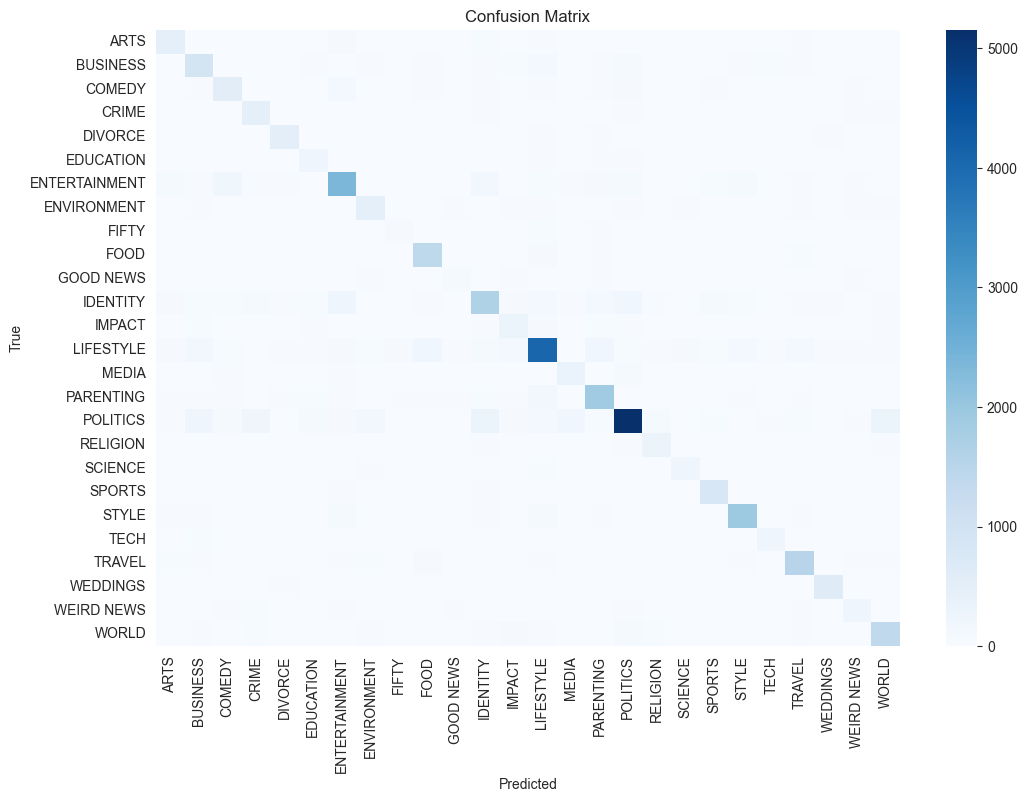

In [10]:
# --- 12. Ma trận nhầm lẫn ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [11]:
# --- 14. Test dự đoán ---
test_text = "The government announced a new policy to improve education."
test_text_clean = clean_text(test_text)
pred_label = cls.predict([test_text_clean])[0]
pred_category = le.inverse_transform([pred_label])[0]
print(f"Văn bản: {test_text}")
print(f"→ Dự đoán: {pred_category}")


Văn bản: The government announced a new policy to improve education.
→ Dự đoán: TECH
